# Assignment 1
## Recreate Fama-French (1993) SMB and HML factors 

### Replication Procedure
1) Main data required is monthly returns, market equity, and book equity
    
    a) Use all non-financial firms (shrcd = 10, 11) which intersect the NYSE, AMEX and NASDAQ (exchcd = 1,2,3) from CRSP and the merged COMPUSTAT database for the financial statement data
    
    b) Data starts in 1962, however end of June of 1963 is first year, with t-1 data being from 1962  
    
2) Clean data appropriately

    a) BE is defined as COMPUSTATs book value of stockholders equity + balance-sheet deferred taxes - book value of preferred stock
    
    b) Negative BE firms are excluded

3) Organize necessary variables for each stock:

    a) Compute B/M_t as BE divided ME (both) in December of year t-1   
    
    b) ME_t as of June of year t
    
    c) All above variables are in logs
    
    d) Returns are computed monthly

4) Sort stocks based on Size and B/M
    
    a) B/M divded into Low, Medium and High, with the distinction for low as the lowest 30%, and high the highest 30%
    
    b) Size divided into Small and Big, with the distinction being the NYSE median breakpoint in June of year t
    
5) Compute value-weighted portfolio return from July of year t to June of year t+1, where the portfolio is rebalanced in June of t+1

6) Compute HML factor as the difference between the average portfolio returns for the High, Small and Big portfolios and the Low, Small and Big portfolios

7) Compute the SMB factor as the different between the average portfolio returns for the Small, L, M and H portfolios and the Big, L, M and H portfolios

### Data

In [2]:
# Imports
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from dateutil.relativedelta import *
from pandas.tseries.offsets import *
import pandas_datareader.data as pdr
from pandas_datareader.famafrench import get_available_datasets

#### Link to WRDS

In [281]:
import wrds
conn = wrds.Connection(wrds_username="santoromano")
# conn.create_pgpass_file()

Loading library list...
Done


#### Imports and Cleans COMPUSTAT Data

Gets data from COMPUSTAT North American - Fundamentals Annual file ('from comp.funda')

GVKEY is the unique company identifier

DATADATE is the date index

AT is total assets

PSTKL is preferred stock liquidation value

TXDITC is deferred taxes

PSTKRV is preferred stock redemption value

SEQ is book equity

PSTK is total preferred stock

In [5]:
# comp = conn.raw_sql("""
#                     select gvkey, datadate, at, pstkl, txditc, pstkrv, seq, pstk
#                     from comp.funda
#                     where indfmt='INDL' 
#                     and datafmt='STD'
#                     and popsrc='D'
#                     and consol='C'
#                     and datadate >= '01/01/1959'
#                     """, 
#                     date_cols=['datadate'])
# comp['year'] = comp['datadate'].dt.year

In [6]:
# comp.to_pickle("raw_compustat_data.pkl")

In [261]:
comp = pd.read_pickle("raw_compustat_data.pkl")

In [265]:
# comp

In [263]:
# Creates Preferred Equity
# either as redemption value, liquidation value or total, and fills blanks with 0
comp['ps']=np.where(comp['pstkrv'].isnull(), comp['pstkl'], comp['pstkrv'])
comp['ps']=np.where(comp['ps'].isnull(),comp['pstk'], comp['ps'])
comp['ps']=np.where(comp['ps'].isnull(),0,comp['ps'])
comp['txditc']=comp['txditc'].fillna(0)

Book value of Equity = Stockholders Equity + Deferred Taxes - Preferred Equity

(BE = SEQ + TXDITC - PS)

In [264]:
# Computes Book Equity
comp['be']=comp['seq']+comp['txditc']-comp['ps']
comp['be']=np.where(comp['be']>0, comp['be'], np.nan) # if be is negative, set as NaN

<font size=4 color=red>
  
**Note**: SAS code from WRDS has 'if BE<0 then BE=NaN'
    
<font>
    
<font size=4 color=green>
  
**Solution**: Does not make a difference
    
<font>

Validation Code:

```python
comp['be_test'] = np.where(comp['be']<0, np.nan, comp['be'])
test = comp[comp['be'] != comp['be_test']].copy()
test.dropna() # empty dataframe
```

In [266]:
# number of years in Compustat
comp=comp.sort_values(by=['gvkey','datadate'])
comp['count']=comp.groupby(['gvkey']).cumcount()

comp=comp[['gvkey','datadate','year','be','count']]

In [267]:
comp

,gvkey,datadate,year,be,count
0,001000,1961-12-31,1961,NaN,0
1,001000,1962-12-31,1962,NaN,1
2,001000,1963-12-31,1963,0.561,2
3,001000,1964-12-31,1964,0.627,3
4,001000,1965-12-31,1965,0.491,4
...,...,...,...,...,...
44983,351590,2019-12-31,2019,11161.229,0
44984,351590,2020-12-31,2020,10033.633,1
44985,351590,2021-12-31,2021,18183.563,2
44986,353444,2021-12-31,2021,40233.000,0


In [268]:
# Stores cleaned COMPUSTAT data locally
# comp.to_pickle("compustat_data.pkl")

#### Imports and Cleans Book Equity Data from Ken French's Website

In [ ]:
get_available_datasets

#### Imports and Cleans CRSP Data

Gets data from CRSP Monthly Stock File ("from crsp.msf")

Join with "event" file ("crsp.msenames") to get historical exchange and share code

PERMNO is the permanent issue number

PERMCO is the permanent company number

DATE is the date index

SHRCD is the share code

EXCHCD is the exchange code

RET is the holding period (monthly) total return

RETX is the holding period (monthly) price return (ie. excluding dividends)

SHROUT is the number of shares outstanding

PRC is the share price

In [3]:
# WRDS SQL Query

# crsp_m = conn.raw_sql("""
#                       select a.permno, a.permco, a.date, b.shrcd, b.exchcd,
#                       a.ret, a.retx, a.shrout, a.prc
#                       from crsp.msf as a
#                       left join crsp.msenames as b
#                       on a.permno=b.permno
#                       and b.namedt<=a.date
#                       and a.date<=b.nameendt
#                       where a.date between '01/01/1959' and '12/31/2022'
#                       and b.exchcd between 1 and 3
#                       """, date_cols=['date']) 

# # change variable format to int
# crsp_m[['permco','permno','shrcd','exchcd']]=crsp_m[['permco','permno','shrcd','exchcd']].astype(int)

# # Line up date to be end of month
# crsp_m['jdate']=crsp_m['date']+MonthEnd(0)

In [270]:
# # Add delisted return
# dlret = conn.raw_sql("""
#                      select permno, dlret, dlstdt 
#                      from crsp.msedelist
#                      """, date_cols=['dlstdt'])

# dlret.permno=dlret.permno.astype(int)
# #dlret['dlstdt']=pd.to_datetime(dlret['dlstdt'])
# dlret['jdate']=dlret['dlstdt']+MonthEnd(0)

# crsp = pd.merge(crsp_m, dlret, how='left',on=['permno','jdate'])

In [271]:
# crsp.to_pickle("raw_crsp_data.pkl")

In [13]:
crsp = pd.read_pickle("raw_crsp_data.pkl")

In [14]:
# crsp

In [15]:
crsp['dlret']=crsp['dlret'].fillna(0)
crsp['ret']=crsp['ret'].fillna(0)

# Return adjusted for delisting
crsp['retadj']=(1+crsp['ret'])*(1+crsp['dlret'])-1

# calculate market equity
crsp['me']=crsp['prc'].abs()*crsp['shrout'] 
crsp=crsp.drop(['dlret','dlstdt','prc','shrout'], axis=1)
crsp=crsp.sort_values(by=['jdate','permco','me'])

In [16]:
# Aggreate Market Cap
# The total market cap (across issues for the same company) is assigned to the 
# issue number with the highest market cap, and all other issues for the
# company are dropped
 
# Sum ME across different permno for same permco for a given date 
crsp_summe = crsp.groupby(['jdate','permco'])['me'].sum().reset_index()

# largest mktcap within a permco/date
crsp_maxme = crsp.groupby(['jdate','permco'])['me'].max().reset_index()

# Join by jdate/maxme to find the permno
crsp1=pd.merge(crsp, crsp_maxme, how='inner', on=['jdate','permco','me']) # df which only contains issue numbers w/ largest me
crsp1=crsp1.drop(['me'], axis=1)

# Joins with sum of me to get the correct market cap info
crsp2=pd.merge(crsp1, crsp_summe, how='inner', on=['jdate','permco'])

# sort by permno and date and also drop duplicates
crsp2=crsp2.sort_values(by=['permno','jdate']).drop_duplicates()

In [17]:
# December Market Cap
crsp2['year']=crsp2['jdate'].dt.year
crsp2['month']=crsp2['jdate'].dt.month
decme=crsp2[crsp2['month']==12]
decme=decme[['permno','date','jdate','me','year']].rename(columns={'me':'dec_me'})

# July to June dates
crsp2['ffdate']=crsp2['jdate']+MonthEnd(-6)
crsp2['ffyear']=crsp2['ffdate'].dt.year
crsp2['ffmonth']=crsp2['ffdate'].dt.month
crsp2['1+retx']=1+crsp2['retx']
crsp2=crsp2.sort_values(by=['permno','date'])

In [18]:
# Computes cummulative returns for every year
crsp2['cumretx']=crsp2.groupby(['permno','ffyear'])['1+retx'].cumprod()

# Lagged cummulative return and market cap
crsp2['lcumretx']=crsp2.groupby(['permno'])['cumretx'].shift(1)
crsp2['lme']=crsp2.groupby(['permno'])['me'].shift(1)

# if first permno then use me/(1+retx) to replace the missing value
crsp2['count']=crsp2.groupby(['permno']).cumcount()
crsp2['lme']=np.where(crsp2['count']==0, crsp2['me']/crsp2['1+retx'], crsp2['lme'])

# baseline me
mebase=crsp2[crsp2['ffmonth']==1][['permno','ffyear', 'lme']].rename(columns={'lme':'mebase'})

# merge result back together
crsp3=pd.merge(crsp2, mebase, how='left', on=['permno','ffyear'])
crsp3['wt']=np.where(crsp3['ffmonth']==1, crsp3['lme'], crsp3['mebase']*crsp3['lcumretx'])

# Increments December market cap by 1 year
decme['year']=decme['year']+1
decme=decme[['permno','year','dec_me']]

In [19]:
# Info as of June
crsp3_jun = crsp3[crsp3['month']==6]

# Merges December t-1 market cap with returns as of June t
crsp_jun = pd.merge(crsp3_jun, decme, how='inner', on=['permno','year'])
crsp_jun=crsp_jun[['permno','date', 'jdate', 'shrcd','exchcd','retadj','me','wt','cumretx','mebase','lme','dec_me']]
crsp_jun=crsp_jun.sort_values(by=['permno','jdate']).drop_duplicates()

In [20]:
# Stores cleaned CRSP data locally
# crsp_jun.to_pickle("crsp_data.pkl")
# crsp3.to_pickle("crsp3_data.pkl")

#### Merge CRSP and Compustat
Merge with CCM Link Table

##### Reads COMPUSTAT and CRSP Data locally

In [82]:
# comp = pd.read_pickle("compustat_data.pkl")
# crsp_jun = pd.read_pickle("crsp_data.pkl")

In [282]:
ccm=conn.raw_sql("""
                  select gvkey, lpermno as permno, linktype, linkprim, 
                  linkdt, linkenddt
                  from crsp.ccmxpf_linktable
                  where substr(linktype,1,1)='L'
                  and (linkprim ='C' or linkprim='P')
                  """, date_cols=['linkdt', 'linkenddt'])

# if linkenddt is missing then set to today date
ccm['linkenddt']=ccm['linkenddt'].fillna(pd.to_datetime('today'))

# Merge COMPUSTAT and CCM Link Table on GVKEY
ccm1=pd.merge(comp[['gvkey','datadate','be', 'count']],ccm,how='left',on=['gvkey'])

# Adds in date columns for next June
ccm1['yearend']=ccm1['datadate']+YearEnd(0)
ccm1['jdate']=ccm1['yearend']+MonthEnd(6)

In [283]:
# Link only if June y is beyond the initial link date, and the final link date
ccm2=ccm1[(ccm1['jdate']>=ccm1['linkdt'])&(ccm1['jdate']<=ccm1['linkenddt'])]
ccm2=ccm2[['gvkey','permno','datadate','yearend', 'jdate','be', 'count']]

# COMPUSTAT and CRSP Merge
ccm_jun=pd.merge(crsp_jun, ccm2, how='inner', on=['permno', 'jdate'])
ccm_jun['beme']=ccm_jun['be']*1000/ccm_jun['dec_me']

In [286]:
# ccm_jun.to_pickle("compustat_crsp_merged.pkl")

### Constructs 2x3 Sort

In [6]:
ccm_jun = pd.read_pickle("compustat_crsp_merged.pkl")
crsp3 = pd.read_pickle("crsp3_data.pkl")

In [7]:
# Selects NYSE stocks for bucket breakdown
# exchcd = 1 and positive beme and positive me and shrcd in (10,11) and at least 2 years in comp
nyse=ccm_jun[(ccm_jun['exchcd']==1) & (ccm_jun['beme']>0) & (ccm_jun['me']>0) & \
             (ccm_jun['count']>=1) & ((ccm_jun['shrcd']==10) | (ccm_jun['shrcd']==11))]

In [8]:
# Size and BE/ME Breakdown

# Size
nyse_sz=nyse.groupby(['jdate'])['me'].median().to_frame().reset_index().rename(columns={'me':'sizemedn'})

# BE/ME
nyse_bm=nyse.groupby(['jdate'])['beme'].describe(percentiles=[0.3, 0.7]).reset_index()
nyse_bm=nyse_bm[['jdate','30%','70%']].rename(columns={'30%':'bm30', '70%':'bm70'})

nyse_breaks = pd.merge(nyse_sz, nyse_bm, how='inner', on=['jdate'])

# join back size and beme breakdown
ccm1_jun = pd.merge(ccm_jun, nyse_breaks, how='left', on=['jdate'])

In [24]:
# function to assign sz and bm bucket
def sz_bucket(row):
    if row['me']==np.nan:
        value=''
    elif row['me']<=row['sizemedn']:
        value='S'
    else:
        value='B'
    return value

def bm_bucket(row):
    if 0<=row['beme']<=row['bm30']:
        value = 'L'
    elif row['beme']<=row['bm70']:
        value='M'
    elif row['beme']>row['bm70']:
        value='H'
    else:
        value=''
    return value

In [9]:
nyse_breaks

,jdate,sizemedn,bm30,bm70
0,1961-06-30,1.718663e+05,0.761766,1.510096
1,1962-06-30,2.618610e+05,0.392291,0.505415
2,1963-06-30,2.567460e+05,0.450994,0.660491
3,1964-06-30,1.921707e+05,0.462265,0.805590
4,1965-06-30,1.841806e+05,0.421957,0.775477
...,...,...,...,...
56,2017-06-30,3.065053e+06,0.302826,0.668757
57,2018-06-30,3.293754e+06,0.284741,0.655523
58,2019-06-30,3.108495e+06,0.352487,0.872011
59,2020-06-30,2.540818e+06,0.308972,0.770254


#### Comparison Breakpoints from Ken French's website



In [124]:
my_breakpoints = nyse_breaks.copy()
my_breakpoints.index = my_breakpoints['jdate']
my_breakpoints.index = my_breakpoints.index.to_period('M')
my_breakpoints

,jdate,sizemedn,bm30,bm70
jdate,,,,
1961-06,1961-06-30,1.718663e+05,0.761766,1.510096
1962-06,1962-06-30,2.618610e+05,0.392291,0.505415
1963-06,1963-06-30,2.567460e+05,0.450994,0.660491
1964-06,1964-06-30,1.921707e+05,0.462265,0.805590
1965-06,1965-06-30,1.841806e+05,0.421957,0.775477
...,...,...,...,...
2017-06,2017-06-30,3.065053e+06,0.302826,0.668757
2018-06,2018-06-30,3.293754e+06,0.284741,0.655523
2019-06,2019-06-30,3.108495e+06,0.352487,0.872011


In [53]:
# get_available_datasets()
size_breakpoints = pdr.DataReader('ME_Breakpoints','famafrench', start='1961-06-01')[0]
size_breakpoints.columns = size_breakpoints.columns.map(str)

be_breakpoints = pdr.DataReader('BE-ME_Breakpoints','famafrench', start='1961-06-01')[0]
be_breakpoints.columns = be_breakpoints.columns.map(str)

In [109]:
median_size = size_breakpoints.loc[::12,'(45, 50)']
size_breaks = pd.merge(my_breakpoints['sizemedn'], median_size, left_index=True, right_index=True)
size_breaks

,sizemedn,"(45, 50)"
1961-06,1.718663e+05,77.77
1962-06,2.618610e+05,58.79
1963-06,2.567460e+05,72.94
1964-06,1.921707e+05,80.33
1965-06,1.841806e+05,85.19
...,...,...
2017-06,3.065053e+06,2826.85
2018-06,3.293754e+06,3228.94
2019-06,3.108495e+06,3047.61
2020-06,2.540818e+06,2579.76


In [130]:
size_breaks.corr()

,sizemedn,"(45, 50)"
sizemedn,1.000000,0.998848
"(45, 50)",0.998848,1.000000


In [135]:
# my_breakpoints.index = my_breakpoints.index.year
# my_breakpoints.index = my_breakpoints.index.astype('period[Y]')

be_30_70 = be_breakpoints.loc[:,['(25, 30)', '(65, 70)']]

be_breaks = pd.merge(my_breakpoints[['bm30','bm70']], be_30_70, left_index=True, right_index=True)
be_breaks

,bm30,bm70,"(25, 30)","(65, 70)"
1961,0.761766,1.510096,0.552,1.141
1962,0.392291,0.505415,0.457,0.952
1963,0.450994,0.660491,0.557,1.178
1964,0.462265,0.805590,0.527,1.008
1965,0.421957,0.775477,0.476,0.925
...,...,...,...,...
2017,0.302826,0.668757,0.276,0.599
2018,0.284741,0.655523,0.261,0.606
2019,0.352487,0.872011,0.327,0.803
2020,0.308972,0.770254,0.290,0.710


In [136]:
be_breaks.corr()

,bm30,bm70,"(25, 30)","(65, 70)"
bm30,1.000000,0.966624,0.983411,0.968152
bm70,0.966624,1.000000,0.925794,0.942252
"(25, 30)",0.983411,0.925794,1.000000,0.981907
"(65, 70)",0.968152,0.942252,0.981907,1.000000


In [85]:
median_size.index
# correct_breakpoints = my_breakpoints.merge(median_size,left_index=True,right_index=True).merge(be_30_70,left_index=True,right_index=True)
# correct_breakpoints

PeriodIndex(['1961-06', '1961-07', '1961-08', '1961-09', '1961-10', '1961-11',
             '1961-12', '1962-01', '1962-02', '1962-03',
             ...
             '2022-02', '2022-03', '2022-04', '2022-05', '2022-06', '2022-07',
             '2022-08', '2022-09', '2022-10', '2022-11'],
            dtype='period[M]', name='Date', length=738)

#### Portfolios based on Levels

In [25]:
# Size portfolio
ccm1_jun['szport']=np.where((ccm1_jun['beme']>0)&(ccm1_jun['me']>0)&(ccm1_jun['count']>=1), ccm1_jun.apply(sz_bucket, axis=1), '')

# Book-to-market portfolio
ccm1_jun['bmport']=np.where((ccm1_jun['beme']>0)&(ccm1_jun['me']>0)&(ccm1_jun['count']>=1), ccm1_jun.apply(bm_bucket, axis=1), '')

# Create positive BE/ME and non-missing book-to-market portfolio variable
ccm1_jun['posbm']=np.where((ccm1_jun['beme']>0)&(ccm1_jun['me']>0)&(ccm1_jun['count']>=1), 1, 0)
ccm1_jun['nonmissport']=np.where((ccm1_jun['bmport']!=''), 1, 0)

In [26]:
# Store portfolio assignment as of June
june=ccm1_jun[['permno','date', 'jdate', 'bmport','szport','posbm','nonmissport']]
june['ffyear']=june['jdate'].dt.year

# Merge back with monthly records
crsp3 = crsp3[['date','permno','shrcd','exchcd','retadj','me','wt','cumretx','ffyear','jdate']]
ccm3 = pd.merge(crsp3, june[['permno','ffyear','szport','bmport','posbm','nonmissport']], how='left', on=['permno','ffyear'])

# Keeping only records that meet the criteria
ccm4 = ccm3[(ccm3['wt']>0) & (ccm3['posbm']==1) & (ccm3['nonmissport']==1) & 
          ((ccm3['shrcd']==10) | (ccm3['shrcd']==11))]

C:\Users\sroma\AppData\Local\Temp\ipykernel_25296\1506937354.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  june['ffyear']=june['jdate'].dt.year


### Portfolio & Factor Construction

In [27]:
# function to calculate value weighted return
def wavg(group, avg_name, weight_name):
    d = group[avg_name]
    w = group[weight_name]
    try:
        return (d * w).sum() / w.sum()
    except ZeroDivisionError:
        return np.nan

#### Factors based on Levels

In [28]:
# Value-weigthed return
vwret = ccm4.groupby(['jdate','szport','bmport']).apply(wavg, 'retadj','wt').to_frame().reset_index().rename(columns={0: 'vwret'})
vwret['sbport'] = vwret['szport'] + vwret['bmport']

# Firm count
vwret_n = ccm4.groupby(['jdate','szport','bmport'])['retadj'].count().reset_index().rename(columns={'retadj':'n_firms'})
vwret_n['sbport'] = vwret_n['szport']+vwret_n['bmport']

# tranpose
ff_factors = vwret.pivot(index='jdate', columns='sbport', values='vwret').reset_index()
ff_nfirms = vwret_n.pivot(index='jdate', columns='sbport', values='n_firms').reset_index()

In [29]:
# create SMB and HML factors
ff_factors['WH']=(ff_factors['BH']+ff_factors['SH'])/2
ff_factors['WL']=(ff_factors['BL']+ff_factors['SL'])/2
ff_factors['WHML'] = ff_factors['WH']-ff_factors['WL']

ff_factors['WB']=(ff_factors['BL']+ff_factors['BM']+ff_factors['BH'])/3
ff_factors['WS']=(ff_factors['SL']+ff_factors['SM']+ff_factors['SH'])/3
ff_factors['WSMB'] = ff_factors['WS']-ff_factors['WB']
ff_factors=ff_factors.rename(columns={'jdate':'date'})

# n firm count
ff_nfirms['H']=ff_nfirms['SH']+ff_nfirms['BH']
ff_nfirms['L']=ff_nfirms['SL']+ff_nfirms['BL']
ff_nfirms['HML']=ff_nfirms['H']+ff_nfirms['L']

ff_nfirms['B']=ff_nfirms['BL']+ff_nfirms['BM']+ff_nfirms['BH']
ff_nfirms['S']=ff_nfirms['SL']+ff_nfirms['SM']+ff_nfirms['SH']
ff_nfirms['SMB']=ff_nfirms['B']+ff_nfirms['S']
ff_nfirms['TOTAL']=ff_nfirms['SMB']
ff_nfirms=ff_nfirms.rename(columns={'jdate':'date'})

In [43]:
ff_factors

sbport,date,BH,BL,BM,SH,SL,SM,WH,WL,WHML,WB,WS,WSMB
0,1961-07-31,NaN,0.017327,0.045662,0.000000,NaN,-0.022321,NaN,NaN,NaN,NaN,NaN,NaN
1,1961-08-31,NaN,0.021898,0.126638,0.119565,NaN,0.091324,NaN,NaN,NaN,NaN,NaN,NaN
2,1961-09-30,NaN,0.024061,0.015504,-0.048544,NaN,-0.004202,NaN,NaN,NaN,NaN,NaN,NaN
3,1961-10-31,NaN,0.004684,0.069231,-0.102041,NaN,-0.067511,NaN,NaN,NaN,NaN,NaN,NaN
4,1961-11-30,NaN,0.072261,0.028777,0.125000,NaN,0.018100,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
724,2021-11-30,-0.045823,-0.000943,-0.031771,-0.035349,-0.068801,-0.013955,-0.040586,-0.034872,-0.005714,-0.026179,-0.039369,-0.013190
725,2021-12-31,0.050632,0.026028,0.060611,0.043962,-0.002917,0.040213,0.047297,0.011555,0.035742,0.045757,0.027086,-0.018671
726,2022-01-31,0.055996,-0.079990,-0.036992,-0.008605,-0.133200,-0.088411,0.023696,-0.106595,0.130291,-0.020329,-0.076738,-0.056410
727,2022-02-28,0.009915,-0.038324,-0.003456,0.024701,-0.000739,0.009384,0.017308,-0.019532,0.036839,-0.010622,0.011115,0.021737


In [300]:
# Value-weigthed return
vwret_log = ccm4_log.groupby(['jdate','szport','bmport']).apply(wavg, 'retadj','wt').to_frame().reset_index().rename(columns={0: 'vwret'})
vwret_log['sbport'] = vwret_log['szport'] + vwret_log['bmport']

# tranpose
log_ff_factors = vwret_log.pivot(index='jdate', columns='sbport', values='vwret').reset_index()

In [301]:
# create SMB and HML factors
log_ff_factors['WH']=(log_ff_factors['BH']+log_ff_factors['SH'])/2
log_ff_factors['WL']=(log_ff_factors['BL']+log_ff_factors['SL'])/2
log_ff_factors['HML_log'] = log_ff_factors['WH']-log_ff_factors['WL']

log_ff_factors['WB']=(log_ff_factors['BL']+log_ff_factors['BM']+log_ff_factors['BH'])/3
log_ff_factors['WS']=(log_ff_factors['SL']+log_ff_factors['SM']+log_ff_factors['SH'])/3
log_ff_factors['SMB_log'] = log_ff_factors['WS']-log_ff_factors['WB']
log_ff_factors=log_ff_factors.rename(columns={'jdate':'date'})

In [302]:
log_ff_factors

sbport,date,BH,BL,BM,SH,SL,SM,WH,WL,HML_log,WB,WS,SMB_log
0,1961-07-31,NaN,0.017327,0.045662,0.000000,NaN,-0.022321,NaN,NaN,NaN,NaN,NaN,NaN
1,1961-08-31,NaN,0.021898,0.126638,0.119565,NaN,0.091324,NaN,NaN,NaN,NaN,NaN,NaN
2,1961-09-30,NaN,0.024061,0.015504,-0.048544,NaN,-0.004202,NaN,NaN,NaN,NaN,NaN,NaN
3,1961-10-31,NaN,0.004684,0.069231,-0.102041,NaN,-0.067511,NaN,NaN,NaN,NaN,NaN,NaN
4,1961-11-30,NaN,0.072261,0.028777,0.125000,NaN,0.018100,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
724,2021-11-30,-0.045823,-0.000943,-0.031771,-0.035349,-0.068801,-0.013955,-0.040586,-0.034872,-0.005714,-0.026179,-0.039369,-0.013190
725,2021-12-31,0.050632,0.026028,0.060611,0.043962,-0.002917,0.040213,0.047297,0.011555,0.035742,0.045757,0.027086,-0.018671
726,2022-01-31,0.055996,-0.079990,-0.036992,-0.008605,-0.133200,-0.088411,0.023696,-0.106595,0.130291,-0.020329,-0.076738,-0.056410
727,2022-02-28,0.009915,-0.038324,-0.003456,0.024701,-0.000739,0.009384,0.017308,-0.019532,0.036839,-0.010622,0.011115,0.021737


### Compare with actual Factors from Ken French Data

In [1]:
# get_available_datasets

In [304]:
# real_ff_factors = pdr.DataReader('6_Portfolios_2x3','famafrench', start='1963-07-01')
# real_ff_factors = real_ff_factors[0]

# real_ff_factors['real_HML'] = (real_ff_factors["SMALL HiBM"] + real_ff_factors["BIG HiBM"])/2 - (real_ff_factors["SMALL LoBM"] + real_ff_factors["BIG LoBM"])/2
# real_ff_factors['real_SMB'] = (real_ff_factors["SMALL LoBM"] + real_ff_factors["ME1 BM2"] + real_ff_factors["SMALL HiBM"])/3 - \
#                          (real_ff_factors["BIG LoBM"] + real_ff_factors["ME2 BM2"] + real_ff_factors["BIG HiBM"])/3

# real_ff_factors.to_pickle("real_ff_factors.pkl")

In [46]:
real_ff_factors = pd.read_pickle("real_ff_factors.pkl")

In [51]:
ff_factors.index = ff_factors['date']
ff_factors.index = ff_factors.index.to_period('M')

compare_factors = pd.merge(ff_factors[['WSMB','WHML']], 
                           real_ff_factors[['real_SMB','real_HML']],
                           how='inner', left_index=True, right_index=True)

In [101]:
# compare_factors

In [59]:
display(compare_factors.corr().style.set_caption('Factor Correlations'))
display(compare_factors.describe().style.set_caption('Factor Summary Statistics'))

,WSMB,WHML,real_SMB,real_HML
WSMB,1.000000,-0.204743,0.992402,-0.155340
WHML,-0.204743,1.000000,-0.204750,0.977218
real_SMB,0.992402,-0.204750,1.000000,-0.169570
real_HML,-0.155340,0.977218,-0.169570,1.000000


,WSMB,WHML,real_SMB,real_HML
count,705.000000,705.000000,705.000000,705.000000
mean,0.002095,0.002585,0.190078,0.293436
std,0.030203,0.029952,3.052694,2.938343
min,-0.170665,-0.136451,-17.228533,-13.972650
25%,-0.015634,-0.014285,-1.661500,-1.380900
50%,0.000872,0.001791,0.118600,0.234800
75%,0.018975,0.017223,2.025100,1.745050
max,0.223343,0.137679,21.424833,12.753700


#### Analysis
...

#### Grade

50 × Corr(RYours, RFF) + 25 × (1 −|μYours − μFF|) + 25 × (1−|σYours − σFF|), 

In [82]:
grade = 50*compare_factors.corr().loc["WHML","real_HML"] \
        + 25*(1 - abs(compare_factors.describe()['WHML'].loc["mean"] - compare_factors.describe()['real_HML'].loc["mean"])) \
        + 25*(1 - abs(compare_factors.describe()['WHML'].loc["std"] - compare_factors.describe()['real_HML'].loc["std"]/100))
grade

91.57538771022499

#### Plot

<AxesSubplot:>

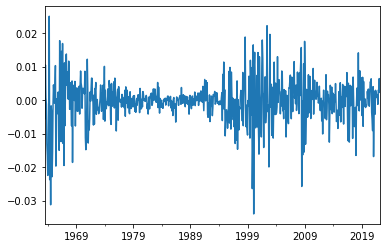

In [100]:
hml_plot = compare_factors[["WHML",'real_HML']].copy()
hml_plot['real_HML'] = hml_plot['real_HML'] / 100
hml_plot['hml_diff'] = hml_plot['WHML'] - hml_plot['real_HML'] 
hml_plot['hml_diff'].plot()